# Data preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

- 각 데이터프레임 변수의 이름은 파일 이름을 그대로 사용함.  
  예: `mBle.parquet` 파일 → 변수 이름 `mBle`
- 전처리하는 데이터프레임의 이름은 'pre_'로 시작함. </br>
  예: `mBle` → `pre_mBle`

In [2]:
import os

# Path for data folder
DATA_DIR = "../data/"

# Main data item list
file_names = [
    "mACStatus", "mScreenStatus", "mUsageStats", "mActivity", "mBle", "mWifi",
    "wHr", "wPedo", "mGps", "mLight","wLight", "mAmbience"
]

data_files = {name: os.path.join(DATA_DIR, f"ch2025_{name}.parquet") for name in file_names}

dfs = {}
for name, file_path in data_files.items():
    dfs[name] = pd.read_parquet(file_path)
    globals()[name] = dfs[name]
    print(f"Loaded {name} with shape {dfs[name].shape}")

Loaded mACStatus with shape (939896, 3)
Loaded mScreenStatus with shape (939653, 3)
Loaded mUsageStats with shape (45197, 3)
Loaded mActivity with shape (961062, 3)
Loaded mBle with shape (21830, 3)
Loaded mWifi with shape (76336, 3)
Loaded wHr with shape (382918, 3)
Loaded wPedo with shape (748100, 9)
Loaded mGps with shape (800611, 3)
Loaded mLight with shape (96258, 3)
Loaded wLight with shape (633741, 3)
Loaded mAmbience with shape (476577, 3)


In [3]:
# Check one of the dataframes
print(f"mACStatus DataFrame:\n{mACStatus.head()}")

mACStatus DataFrame:
  subject_id           timestamp  m_charging
0       id01 2024-06-26 12:03:00           0
1       id01 2024-06-26 12:04:00           0
2       id01 2024-06-26 12:05:00           0
3       id01 2024-06-26 12:06:00           0
4       id01 2024-06-26 12:07:00           0


## Load training and test set

- Training set dataframe: `train_df`
- Test set dataframe: `test_df`

In [4]:
# Load train and test set
train_df = pd.read_csv(os.path.join(DATA_DIR, "ch2025_metrics_train.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "ch2025_submission_sample.csv"))

# Combine train and test
total_df = pd.concat([train_df, test_df], axis=0)

print("total_df.shape:", total_df.shape)
total_df.head()

total_df.shape: (700, 9)


,subject_id,sleep_date,lifelog_date,Q1,Q2,Q3,S1,S2,S3
0,id01,2024-06-27,2024-06-26,0,0,0,0,0,1
1,id01,2024-06-28,2024-06-27,0,0,0,0,1,1
2,id01,2024-06-29,2024-06-28,1,0,0,1,1,1
3,id01,2024-06-30,2024-06-29,1,0,1,2,0,0
4,id01,2024-07-01,2024-06-30,0,1,1,1,1,1


# 1. mACStatus
- 스마트폰 충전 여부 (0: no, 1: charging)
- 1분 단위
---
- **데이터에서 아웃 (temporal)**

In [5]:
print("mACStatus DataFrame:\n", mACStatus.head(3))

mACStatus DataFrame:
   subject_id           timestamp  m_charging
0       id01 2024-06-26 12:03:00           0
1       id01 2024-06-26 12:04:00           0
2       id01 2024-06-26 12:05:00           0


# 2. mScreenStatus
- 스마트폰 스크린 사용 여부 (0: no, 1: using)
- 1분 단위
---
- **데이터에서 아웃 → mUsageStats에 흡수**

In [6]:
print("mScreenStatus DataFrame:\n", mScreenStatus.head(3))

mScreenStatus DataFrame:
   subject_id           timestamp  m_screen_use
0       id01 2024-06-26 12:03:00             0
1       id01 2024-06-26 12:04:00             0
2       id01 2024-06-26 12:05:00             0


# 3. mUsageStats
- timestamp 당 사용한 app과 사용시간(ms단위)
- 10분 단위(불규칙적)
---
- m_usage_stats 중 사용시간만 합쳐서 사용

In [7]:
print("mUsageStats DataFrame:\n", mUsageStats.head(3))

mUsageStats DataFrame:
   subject_id           timestamp  \
0       id01 2024-06-26 13:00:00   
1       id01 2024-06-26 13:10:00   
2       id01 2024-06-26 13:20:00   

                                       m_usage_stats  
0  [{'app_name': ' 캐시워크', 'total_time': 69}, {'ap...  
1  [{'app_name': '통화', 'total_time': 26419}, {'ap...  
2  [{'app_name': '메시지', 'total_time': 388651}, {'...  


In [8]:
# Extract only subject_id and timestamp columns
prep_mUsageStats = mUsageStats[['subject_id', 'timestamp']].copy()

# Calculate sum of 'total_time' for each row
def sum_usage_time(usage_stats):
    return sum(usage.get('total_time', 0) for usage in usage_stats)

prep_mUsageStats['m_usage_time'] = mUsageStats['m_usage_stats'].apply(sum_usage_time)

In [9]:
print(prep_mUsageStats.head())

  subject_id           timestamp  m_usage_time
0       id01 2024-06-26 13:00:00          7955
1       id01 2024-06-26 13:10:00        490306
2       id01 2024-06-26 13:20:00        599985
3       id01 2024-06-26 13:30:00        212438
4       id01 2024-06-26 13:50:00        118178


# 4. mActivity

- 각 timestamp별로 어떤 활동(m_activity)을 했는지
---
- 새로운 변수 met_activity 생성
    - m_activity에 MET(운동량 지수)를 매핑
    - 시간대 (00~08 / 08~18 / 18~00) 별로 weight 을 달리 주어(0.3 / 0.7 / 1.0) 저녁일수록 더 영향을 주는 활동임을 반영
- met_activity 변수만 저장

In [10]:
print("mActivity DataFrame:\n", mActivity.head(3))

mActivity DataFrame:
   subject_id           timestamp  m_activity
0       id01 2024-06-26 12:03:00           4
1       id01 2024-06-26 12:04:00           0
2       id01 2024-06-26 12:05:00           0


In [11]:
# Copy required columns from mActivity
prep_mActivity = mActivity[['subject_id', 'timestamp', 'm_activity']].copy()

# MET values for each activity type
activity_to_met = {0: 1.3, 1: 7.2, 2: 2.3, 3: 1.1, 4: 1.0, 5: 1.3, 7: 3.4, 8: 8.0}

# Function for time-based weight
def get_time_weight(ts):
    hour = ts.hour
    if 0 <= hour < 8:
        return 0.3
    elif 8 <= hour < 18:
        return 0.7
    else:
        return 1.0

# Convert 'timestamp' to datetime
prep_mActivity['timestamp'] = pd.to_datetime(prep_mActivity['timestamp'])

# Calculate weighted MET value for each row
prep_mActivity['met_activity'] = prep_mActivity.apply(
    lambda row: activity_to_met.get(row['m_activity'], 1.0) * get_time_weight(row['timestamp']), axis=1
)

# Keep only final columns
prep_mActivity = prep_mActivity[['subject_id', 'timestamp', 'met_activity']]

In [12]:
print(prep_mActivity.head(10))

  subject_id           timestamp  met_activity
0       id01 2024-06-26 12:03:00          0.70
1       id01 2024-06-26 12:04:00          0.91
2       id01 2024-06-26 12:05:00          0.91
3       id01 2024-06-26 12:06:00          0.91
4       id01 2024-06-26 12:07:00          0.91
5       id01 2024-06-26 12:08:00          0.91
6       id01 2024-06-26 12:09:00          0.91
7       id01 2024-06-26 12:10:00          0.91
8       id01 2024-06-26 12:11:00          0.77
9       id01 2024-06-26 12:12:00          0.77


# 5. mBle
- timestampe당 주변 Bluetooth 기기들의 address, device class, rssi 값 저장
- address : 블루투스 기기의 고유식별자 (MAC address)
- device_class : 블루투스 기기의 class(분류)
- rssi : 신호 세기, 기기로부터 수신된 신호의 강도 (0에 가까운 값을수록 신호 강함)
--- 
- 기기가 가까이 있으면 전자파로 수면에 방해를 줄 수 있으므로, rssi 값만 고려하여 변수를 생성
- 변수 이름 wb_rssi (weighted bluetooth rssi)
- weighted rssi 생성 방법
    - 각 timestamp에 대해 다음과 같이 계산
    $$
    \text{weighted rssi} = \sum e^{\frac{\text{rssi}}{10}}
    $$
- 다른 방식으로 변수를 만들 수도 있음
    - 예: 기준에 따라 범주(label) 나누고 → sigmoid function 으로 변환 (주형)

In [13]:
print("mBle DataFrame:\n", mBle.head(3))

mBle DataFrame:
   subject_id           timestamp  \
0       id01 2024-06-26 12:13:00   
1       id01 2024-06-26 12:23:00   
2       id01 2024-06-26 12:33:00   

                                               m_ble  
0  [{'address': '00:15:7C:11:80:8D', 'device_clas...  
1  [{'address': '0A:B1:26:4D:76:21', 'device_clas...  
2  [{'address': '04:F5:AE:39:95:E0', 'device_clas...  


In [14]:
# Extract 'subject_id' and 'timestamp' columns
prep_mBle = mBle[['subject_id', 'timestamp']].copy()

# Calculate weighted bluetooth RSSI for each row
def weighted_ble_rssi(ble_stats):
    return sum(np.exp(ble.get('rssi', 0) / 10) for ble in ble_stats)

prep_mBle['wb_rssi'] = mBle['m_ble'].apply(weighted_ble_rssi)

In [15]:
print(prep_mBle.head(10))

  subject_id           timestamp   wb_rssi
0       id01 2024-06-26 12:13:00  0.102155
1       id01 2024-06-26 12:23:00  0.098621
2       id01 2024-06-26 12:33:00  0.037712
3       id01 2024-06-26 13:23:00  0.017129
4       id01 2024-06-26 14:23:00  0.000258
5       id01 2024-06-26 14:33:00  0.014149
6       id01 2024-06-26 14:53:00  0.041060
7       id01 2024-06-26 15:13:00  0.041294
8       id01 2024-06-26 15:23:00  0.039764
9       id01 2024-06-26 15:43:00  0.035066


# 6. mWifi
- timestampe당 주변 Wifi 기기들의 bssid, rssi 값 저장
- bssid : 무선 액세스 포인트의 고유식별자 (MAC address)
- rssi : 신호 세기, 기기로부터 수신된 신호의 강도 (0에 가까운 값을수록 신호 강함)
--- 
mBle와 같은 방식으로,
- 기기가 가까이 있으면 전자파로 수면에 방해를 줄 수 있으므로, rssi 값만 고려하여 변수를 생성
- 변수 이름 ww_rssi (weighted wifi rssi)
- weighted rssi 생성 방법
    - 각 timestamp에 대해 다음과 같이 계산
    $$
    \text{weighted rssi} = \sum e^{\frac{\text{rssi}}{10}}
    $$
- 마찬가지로, 다른 방식으로 변수를 만들 수도 있음
    - 예: 기준에 따라 범주(label) 나누고 → sigmoid function 으로 변환 (주형)

In [16]:
print("mWifi DataFrame:\n", mWifi.head(3))

mWifi DataFrame:
   subject_id           timestamp  \
0       id01 2024-06-26 12:03:00   
1       id01 2024-06-26 12:13:00   
2       id01 2024-06-26 12:23:00   

                                              m_wifi  
0  [{'bssid': 'a0:0f:37:9a:5d:8b', 'rssi': -78}, ...  
1  [{'bssid': 'a0:0f:37:9a:5d:8b', 'rssi': -79}, ...  
2  [{'bssid': '10:e3:c7:0a:74:d1', 'rssi': -78}, ...  


In [17]:
# Extract 'subject_id' and 'timestamp' columns
prep_mWifi = mWifi[['subject_id', 'timestamp']].copy()

# Calculate weighted wifi RSSI for each row
def weighted_wifi_rssi(wifi_stats):
    return sum(np.exp(wifi.get('rssi', 0) / 10) for wifi in wifi_stats)

prep_mWifi['ww_rssi'] = mWifi['m_wifi'].apply(weighted_wifi_rssi)

In [18]:
print(prep_mWifi.head(3))

  subject_id           timestamp   ww_rssi
0       id01 2024-06-26 12:03:00  0.202476
1       id01 2024-06-26 12:13:00  0.091135
2       id01 2024-06-26 12:23:00  0.063361


# 7. wHr
- timestamp 당 초당 heart_rate
---
- timestamp 당 평균 heart_rate를 avg_heart_rate 로 저장

In [19]:
print("wHr DataFrame:\n", wHr.head(3))

wHr DataFrame:
   subject_id           timestamp  \
0       id01 2024-06-26 12:23:00   
1       id01 2024-06-26 12:24:00   
2       id01 2024-06-26 12:25:00   

                                          heart_rate  
0  [134, 134, 135, 133, 134, 135, 134, 135, 134, ...  
1  [123, 122, 121, 120, 121, 121, 120, 118, 119, ...  
2  [120, 119, 117, 116, 119, 121, 123, 123, 121, ...  


In [20]:
prep_wHr = wHr[['subject_id', 'timestamp']].copy()

# Calculate average heart rate for each row and store in 'avg_heart_rate'
prep_wHr['avg_heart_rate'] = wHr['heart_rate'].apply(lambda x: np.mean(x))

In [21]:
print(prep_wHr.head(3))

  subject_id           timestamp  avg_heart_rate
0       id01 2024-06-26 12:23:00      130.794872
1       id01 2024-06-26 12:24:00      120.500000
2       id01 2024-06-26 12:25:00      119.850000


# 8. wPedo
- Step count data and related information measured by the smartwatch.
- burned calories, distance, speed, steps, step_frequency
---
- running_step, walking_step, step, step_frequency drop (Why?)
- distance, burned calories 만 살림

In [22]:
print("wPedo DataFrame:\n", wPedo.head(3))

wPedo DataFrame:
   subject_id           timestamp  step  step_frequency  running_step  \
0       id01 2024-06-26 12:09:00    10        0.166667             0   
1       id01 2024-06-26 12:10:00     0        0.000000             0   
2       id01 2024-06-26 12:11:00     0        0.000000             0   

   walking_step  distance     speed  burned_calories  
0             0      8.33  0.138833              0.0  
1             0      0.00  0.000000              0.0  
2             0      0.00  0.000000              0.0  


In [23]:
prep_wPedo = wPedo[['subject_id', 'timestamp']].copy()

# Keep only subject_id, timestamp, distance, and burned_calories
prep_wPedo = wPedo[['subject_id', 'timestamp', 'distance', 'burned_calories']].copy()

In [24]:
print(prep_wPedo.head(3))

  subject_id           timestamp  distance  burned_calories
0       id01 2024-06-26 12:09:00      8.33              0.0
1       id01 2024-06-26 12:10:00      0.00              0.0
2       id01 2024-06-26 12:11:00      0.00              0.0


# 9. mGps
- m_gps
    - atitude, longitude, altitude, speed
- 12 times per minute
- latitude and longitude converted to relative coordinates for privacy protection
---
- 각 timestamp 당 latitude, longitude, altitude, speed 평균값을 추가.
- 변수 이름은 avg_latitude, avg_longitude, avg_altitude, avg_speed


In [25]:
print("mGps DataFrame:\n", mGps.head(3))

mGps DataFrame:
   subject_id           timestamp  \
0       id01 2024-06-26 12:03:00   
1       id01 2024-06-26 12:04:00   
2       id01 2024-06-26 12:05:00   

                                               m_gps  
0  [{'altitude': 110.6, 'latitude': 0.2077385, 'l...  
1  [{'altitude': 110.8, 'latitude': 0.2078068, 'l...  
2  [{'altitude': 110.7, 'latitude': 0.2078214, 'l...  


In [26]:
# Extract needed columns
prep_mGps = mGps[['subject_id', 'timestamp']].copy()

# Function to calculate averages for each list of gps dicts
def calc_gps_avgs(gps_list, key):
    vals = [item.get(key, np.nan) for item in gps_list if item.get(key) is not None]
    return np.mean(vals) if vals else np.nan

prep_mGps['avg_latitude'] = mGps['m_gps'].apply(lambda gps: calc_gps_avgs(gps, 'latitude'))
prep_mGps['avg_longitude'] = mGps['m_gps'].apply(lambda gps: calc_gps_avgs(gps, 'longitude'))
prep_mGps['avg_altitude'] = mGps['m_gps'].apply(lambda gps: calc_gps_avgs(gps, 'altitude'))
prep_mGps['avg_speed'] = mGps['m_gps'].apply(lambda gps: calc_gps_avgs(gps, 'speed'))

In [27]:
print(prep_mGps.head(3))

  subject_id           timestamp  avg_latitude  avg_longitude  avg_altitude  \
0       id01 2024-06-26 12:03:00      0.207788       0.169974    110.763636   
1       id01 2024-06-26 12:04:00      0.207812       0.169962    110.718182   
2       id01 2024-06-26 12:05:00      0.207829       0.169959    110.709091   

   avg_speed  
0   0.170755  
1   0.028209  
2   0.039736  


# 10. wLight & 11. mLight
- 10분 단위
- m_light : Ambient light in lx unit
- w_light : Ambient light in lx unit
--- 
- 둘 중에 결측이 적은 wLight 사용
- 따로 전처리 필요 없음


In [28]:
print("mLight DataFrame:\n", mLight.head(3))
print("\n")
print("wLight DataFrame:\n", wLight.head(3))

mLight DataFrame:
   subject_id           timestamp  m_light
0       id01 2024-06-26 12:03:00    534.0
1       id01 2024-06-26 12:13:00    846.0
2       id01 2024-06-26 12:23:00    826.0


wLight DataFrame:
   subject_id           timestamp  w_light
0       id01 2024-06-26 12:17:00    633.0
1       id01 2024-06-26 12:18:00    483.0
2       id01 2024-06-26 12:19:00    541.0


In [29]:
prep_wLight = wLight

In [30]:
print(prep_wLight.head(3))

  subject_id           timestamp  w_light
0       id01 2024-06-26 12:17:00    633.0
1       id01 2024-06-26 12:18:00    483.0
2       id01 2024-06-26 12:19:00    541.0


# 12. mAbience
- Audio-based labels detected on smartphones. Recorded once every 2 minutes.
- ambience_labels: List of the top 10 labels along with their respective probabilities.
---
- 일단은 baseline 대로 바꿈
    - top_10_label에 있는 항목들이 row의 m_ambience에 존재할 경우
    - probability 를 모두 더해서 prob_ambience 값을 저장
- (건호)님이 하신 거로 나중에 바꾸면 될 거 같습니다!

In [31]:
print("mAmbience DataFrame:\n", mAmbience.head(3))

mAmbience DataFrame:
   subject_id           timestamp  \
0       id01 2024-06-26 13:00:10   
1       id01 2024-06-26 13:02:10   
2       id01 2024-06-26 13:04:10   

                                          m_ambience  
0  [[Music, 0.30902618], [Vehicle, 0.081680894], ...  
1  [[Music, 0.62307084], [Vehicle, 0.021118319], ...  
2  [[Horse, 0.25209898], [Animal, 0.24263993], [C...  


In [32]:
'''
# List of top 10 labels
top_10_labels = [
    "Inside, small room", "Speech", "Silence", "Music",
    "Narration, monologue", "Child speech, kid speaking",
    "Conversation", "Speech synthesizer", "Shout", "Babbling"
]

def calc_prob_ambience(amb_list):
    # Check if amb_list is None or has zero length
    if amb_list is None or len(amb_list) == 0:
        return 0.0
    prob_sum = 0.0
    for arr in amb_list:
        if isinstance(arr, (list, np.ndarray)) and len(arr) == 2:
            label = arr[0]
            try:
                prob = float(arr[1])
            except:
                prob = 0.0
            if label in top_10_labels:
                prob_sum += prob
    return prob_sum

prep_mAmbience = mAmbience[['subject_id', 'timestamp']].copy()
prep_mAmbience['prob_ambience'] = mAmbience['m_ambience'].apply(calc_prob_ambience)
'''

'\n# List of top 10 labels\ntop_10_labels = [\n    "Inside, small room", "Speech", "Silence", "Music",\n    "Narration, monologue", "Child speech, kid speaking",\n    "Conversation", "Speech synthesizer", "Shout", "Babbling"\n]\n\ndef calc_prob_ambience(amb_list):\n    # Check if amb_list is None or has zero length\n    if amb_list is None or len(amb_list) == 0:\n        return 0.0\n    prob_sum = 0.0\n    for arr in amb_list:\n        if isinstance(arr, (list, np.ndarray)) and len(arr) == 2:\n            label = arr[0]\n            try:\n                prob = float(arr[1])\n            except:\n                prob = 0.0\n            if label in top_10_labels:\n                prob_sum += prob\n    return prob_sum\n\nprep_mAmbience = mAmbience[[\'subject_id\', \'timestamp\']].copy()\nprep_mAmbience[\'prob_ambience\'] = mAmbience[\'m_ambience\'].apply(calc_prob_ambience)\n'

In [33]:
import ast

# 1. Load weight dictionary
weight_df = pd.read_csv('mAmbience_weight.csv')
weight_dict = dict(zip(weight_df['category'], weight_df['Q1']))

# 2. Define weighted probability sum function
def calc_weighted_prob(ambience_list, weight_dict):
    total = 0.0
    for label, prob in ambience_list:
        weight = weight_dict.get(label, 0)
        try:
            prob_f = float(prob)
        except (ValueError, TypeError):
            prob_f = 0.0
        total += weight * prob_f
    return total


# 3. If m_ambience contains ndarray or string, process to list
def to_pylist(val):
    if isinstance(val, str):
        return ast.literal_eval(val)
    elif hasattr(val, "tolist"):  # numpy array
        return val.tolist()
    return val

# 4. Copy mAmbience, create new DataFrame
prep_mAmbience = mAmbience.copy()
prep_mAmbience['m_ambience'] = prep_mAmbience['m_ambience'].apply(to_pylist)

# 5. Calculate w_prob_sum and save in new column
prep_mAmbience['w_prob_sum'] = prep_mAmbience['m_ambience'].apply(lambda x: calc_weighted_prob(x, weight_dict))

# 결과 확인
prep_mAmbience = prep_mAmbience[['timestamp', 'subject_id','w_prob_sum']]

In [34]:
print(prep_mAmbience.head(3))

            timestamp subject_id  w_prob_sum
0 2024-06-26 13:00:10       id01    0.058762
1 2024-06-26 13:02:10       id01    0.073368
2 2024-06-26 13:04:10       id01    0.130239


# Merge!









### Generate df_merge
- 각 전처리 데이터마다, subject_id별로 가장 이른 timestamp(min)와 가장 늦은 timestamp(max)을 찾음
- 각 파일에서 추출한 min/max timestamp 중 가장 이른 시간을 min_time, 가장 늦은 시간을 max_time으로 설정
    - min_time과 max_time이 10분 단위가 아닐 경우, min_time은 내림(가장 가까운 이전 10분), max_time은 올림(가장 가까운 이후 10분)으로 변환
- 각 subject_id별로 모든 전처리 데이터에서의 최소~최대 timestamp 구간을 10분 단위로 생성하여, 전체 subject의 타임라인을 merge_df로 통합


In [35]:
# List of all preprocessed DataFrame variable names (already loaded in the session)
preprocessed_files = [
    prep_mActivity,prep_mUsageStats, prep_mAmbience,
    prep_mBle, prep_mGps,prep_mWifi, prep_wHr, prep_wLight, prep_wPedo
]

result_list = []

# Get all unique subject_ids (assume every file has subject_id column)
all_ids = sorted(set(np.concatenate([df['subject_id'].unique() for df in preprocessed_files])))

for sid in all_ids:
    min_times, max_times = [], []
    # Find min/max timestamp per file for the current subject_id
    for df in preprocessed_files:
        df_id = df[df['subject_id'] == sid]
        if len(df_id) > 0:
            min_times.append(df_id['timestamp'].min())
            max_times.append(df_id['timestamp'].max())
    # Combine all min/max times
    if len(min_times) == 0 or len(max_times) == 0:
        continue  # No data for this id in any file

    # Get global min_time and max_time across all files (as pd.Timestamp)
    min_time = pd.to_datetime(min(min_times))
    max_time = pd.to_datetime(max(max_times))

    # Floor min_time to nearest 10min, Ceil max_time to nearest 10min
    def floor_10min(ts):
        return ts - pd.Timedelta(minutes=ts.minute % 10, seconds=ts.second, microseconds=ts.microsecond)
    def ceil_10min(ts):
        if ts.minute % 10 == 0 and ts.second == 0 and ts.microsecond == 0:
            return ts
        return ts + pd.Timedelta(minutes=10 - ts.minute % 10, seconds=-ts.second, microseconds=-ts.microsecond)

    min_time_10 = floor_10min(min_time)
    max_time_10 = ceil_10min(max_time)

    # Create timestamp range for this subject_id
    timestamps = pd.date_range(start=min_time_10, end=max_time_10, freq='10min')

    # Create DataFrame for this subject_id
    df_id = pd.DataFrame({'subject_id': sid, 'timestamp': timestamps})
    result_list.append(df_id)

# Concatenate all results
merge_df = pd.concat(result_list, ignore_index=True)

In [36]:
print("merge dataframe:\n", merge_df)
print("merge_df shape\n", merge_df.shape)

merge dataframe:
        subject_id           timestamp
0            id01 2024-06-26 12:00:00
1            id01 2024-06-26 12:10:00
2            id01 2024-06-26 12:20:00
3            id01 2024-06-26 12:30:00
4            id01 2024-06-26 12:40:00
...           ...                 ...
122276       id10 2024-09-26 23:20:00
122277       id10 2024-09-26 23:30:00
122278       id10 2024-09-26 23:40:00
122279       id10 2024-09-26 23:50:00
122280       id10 2024-09-27 00:00:00

[122281 rows x 2 columns]
merge_df shape
 (122281, 2)


### Merging all preprocessed data
1. prep_mUsageStats
    1. 같은 timestamp 에 대해 m_usage_time 값 할당
    2. (결측치 생길 수 있음) → 일단은 놔둔다
2. prep_mActivity
    1. merge_df에 met_activity 열 생성
    2. 모든 row 에 대해서 
        1. row n의 timestamp 가 가장 가까운 merge_df의 row의 met_activity 열에 prep_mActivity row n의 met_activity 값을 더해줌. 
3. prep_mBle
    1. merge_df에 wb_rssi 열 생성
    2. 모든 row에 대해서
        1. row n의 timestamp 가 가장 가까운 merge_df의 row의 wb_rssi 열에 prep_mBle의 wb_rssi 값 할당
4. prep_mWifi
    1. merge_df에 ww_rssi 열 생성
    2. 모든 row에 대해서
        1. row n의 timestamp가 가장 가까운 merge_df의 row의 ww_rssi 열에 prep_mWifi의 ww_rssi 값 할당
5. wHr
    1. merge_df에 avg_heart_rate 열 생성
    2. 모든 row 에 대해서 
        1. row n의 timestamp 가 가장 가까운 merge_df의 row의 avg_heart_rate 열에 prep_wHr row n의 avg_heart_rate 값을 더해주고 더한 값들의 평균을 최종 저장
6. wPedo
    1. merge_df에 distance, burned_calories 열 생성
    2. 모든 row 에 대해서
        1. row n의 timestamp 가 가장 가까운 merge_df의 row의 distance 열에 
        prep_wPedo row n의 distance 값을 더해줌
        2. 위의 과정의 distance, burned_calories 열들에 대해 실행
7. mGps
    1. merge_df에 avg_latitude, avg_longitude, avg_altitude, avg_speed 열 생성
    2. 모든 row 에 대해서
        1. row n의 timestamp가 가장 가까운 merge_df의 row의 avg_latitude 열에
        prep_mGps row n의 avg_latitude 값들의 평균을 저장
        2. 위의 과정을 avg_latitude, avg_longitude, avg_altitude, avg_speed 열들에 대해 실행
8. wLight
    1. merge_df에 avg_light 열 생성
    2. 모든 row 에 대해서 
        1. row n의 timestamp 가 가장 가까운 merge_df의 row의 avg_light 열에 prep_wLight row n의 w_light 값을 더해주고 더한 값들의 평균을 최종 저장
9. mAmbience
    1. merge_df에 avg_prob_ambience 열 생성
    2. 모든 row 에 대해서 
        1. row n의 timestamp 가 가장 가까운 merge_df의 row의 avg_prob_ambience 열에 
        prep_wAmbience row n의 prob_ambience 값을 더해주고 더한 값들의 평균을 최종 저장

In [ ]:
# Sort and reset index
merge_df = merge_df.sort_values(['subject_id', 'timestamp']).reset_index(drop=True)

# Add columns
merge_df['m_usage_time'] = np.nan
merge_df['met_activity'] = 0.0
merge_df['wb_rssi'] = np.nan
merge_df['ww_rssi'] = np.nan

all_ids = merge_df['subject_id'].unique()

for sid in all_ids:
    merge_mask = (merge_df['subject_id'] == sid)

    # 1. prep_mUsageStats: assign by exact match
    usage = prep_mUsageStats[prep_mUsageStats['subject_id'] == sid].set_index('timestamp')
    merge_df.loc[merge_mask, 'm_usage_time'] = merge_df.loc[merge_mask, 'timestamp'].map(usage['m_usage_time'])
    print(f"[{sid}] mUsageStats merge complete.")

    # 2. prep_mActivity: closest timestamp, sum if multiple
    activity = prep_mActivity[prep_mActivity['subject_id'] == sid]
    for _, row in activity.iterrows():
        idx = (merge_df[merge_mask]['timestamp'] - row['timestamp']).abs().idxmin()
        merge_df.loc[idx, 'met_activity'] += row['met_activity']
    print(f"[{sid}] mActivity merge complete.")

    # 3. prep_mBle: closest timestamp, assign
    ble = prep_mBle[prep_mBle['subject_id'] == sid]
    for _, row in ble.iterrows():
        idx = (merge_df[merge_mask]['timestamp'] - row['timestamp']).abs().idxmin()
        merge_df.loc[idx, 'wb_rssi'] = row['wb_rssi']
    print(f"[{sid}] mBle merge complete.")

    # 4. prep_mWifi: closest timestamp, assign
    wifi = prep_mWifi[prep_mWifi['subject_id'] == sid]
    for _, row in wifi.iterrows():
        idx = (merge_df[merge_mask]['timestamp'] - row['timestamp']).abs().idxmin()
        merge_df.loc[idx, 'ww_rssi'] = row['ww_rssi']
    print(f"[{sid}] mWifi merge complete.")

    # 14m 30s

[id01] mUsageStats merge complete.
[id01] mActivity merge complete.
[id01] mBle merge complete.
[id01] mWifi merge complete.
[id02] mUsageStats merge complete.
[id02] mActivity merge complete.
[id02] mBle merge complete.
[id02] mWifi merge complete.
[id03] mUsageStats merge complete.
[id03] mActivity merge complete.
[id03] mBle merge complete.
[id03] mWifi merge complete.
[id04] mUsageStats merge complete.
[id04] mActivity merge complete.
[id04] mBle merge complete.
[id04] mWifi merge complete.
[id05] mUsageStats merge complete.
[id05] mActivity merge complete.
[id05] mBle merge complete.
[id05] mWifi merge complete.
[id06] mUsageStats merge complete.
[id06] mActivity merge complete.
[id06] mBle merge complete.
[id06] mWifi merge complete.
[id07] mUsageStats merge complete.
[id07] mActivity merge complete.
[id07] mBle merge complete.
[id07] mWifi merge complete.
[id08] mUsageStats merge complete.
[id08] mActivity merge complete.
[id08] mBle merge complete.
[id08] mWifi merge complete.


In [ ]:
# 5, 6, 7

for sid in all_ids:
    merge_mask = (merge_df['subject_id'] == sid)
    
    # 5. prep_wHr (avg_heart_rate, 평균)
    merge_df.loc[merge_mask, 'sum_heart_rate'] = 0.0
    merge_df.loc[merge_mask, 'count_heart_rate'] = 0
    merge_df.loc[merge_mask, 'avg_heart_rate'] = np.nan

    wh = prep_wHr[prep_wHr['subject_id'] == sid]
    for _, row in wh.iterrows():
        idx = (merge_df[merge_mask]['timestamp'] - row['timestamp']).abs().idxmin()
        merge_df.loc[idx, 'sum_heart_rate'] += row['avg_heart_rate']
        merge_df.loc[idx, 'count_heart_rate'] += 1
    mask = (merge_df['subject_id'] == sid) & (merge_df['count_heart_rate'] > 0)
    merge_df.loc[mask, 'avg_heart_rate'] = merge_df.loc[mask, 'sum_heart_rate'] / merge_df.loc[mask, 'count_heart_rate']
    merge_df.drop(['sum_heart_rate', 'count_heart_rate'], axis=1, inplace=True)
    print(f"[{sid}] wHr merge complete.")

    # 6. prep_wPedo (distance, burned_calories: 단순 합)
    merge_df.loc[merge_mask, 'distance'] = 0.0
    merge_df.loc[merge_mask, 'burned_calories'] = 0.0

    wp = prep_wPedo[prep_wPedo['subject_id'] == sid]
    for _, row in wp.iterrows():
        idx = (merge_df[merge_mask]['timestamp'] - row['timestamp']).abs().idxmin()
        merge_df.loc[idx, 'distance'] += row['distance']
        merge_df.loc[idx, 'burned_calories'] += row['burned_calories']
    print(f"[{sid}] wPedo merge complete.")

    # 7. prep_mGps (4개, 평균)
    for col in ['avg_latitude', 'avg_longitude', 'avg_altitude', 'avg_speed']:
        merge_df.loc[merge_mask, 'sum_' + col] = 0.0
        merge_df.loc[merge_mask, 'count_' + col] = 0
        merge_df.loc[merge_mask, col] = np.nan

    mgps = prep_mGps[prep_mGps['subject_id'] == sid]
    for _, row in mgps.iterrows():
        idx = (merge_df[merge_mask]['timestamp'] - row['timestamp']).abs().idxmin()
        for col in ['avg_latitude', 'avg_longitude', 'avg_altitude', 'avg_speed']:
            val = row[col]
            merge_df.loc[idx, 'sum_' + col] += val
            merge_df.loc[idx, 'count_' + col] += 1
    for col in ['avg_latitude', 'avg_longitude', 'avg_altitude', 'avg_speed']:
        mask_gps = (merge_df['subject_id'] == sid) & (merge_df['count_' + col] > 0)
        merge_df.loc[mask_gps, col] = merge_df.loc[mask_gps, 'sum_' + col] / merge_df.loc[mask_gps, 'count_' + col]
        merge_df.drop(['sum_' + col, 'count_' + col], axis=1, inplace=True)
    print(f"[{sid}] mGps merge complete.")


In [ ]:
# 8, 9

for sid in all_ids:
    merge_mask = (merge_df['subject_id'] == sid)

    # 8. prep_wLight (평균)
    merge_df.loc[merge_mask, 'sum_light'] = 0.0
    merge_df.loc[merge_mask, 'count_light'] = 0
    merge_df.loc[merge_mask, 'avg_light'] = np.nan

    wl = prep_wLight[prep_wLight['subject_id'] == sid]
    for _, row in wl.iterrows():
        idx = (merge_df[merge_mask]['timestamp'] - row['timestamp']).abs().idxmin()
        merge_df.loc[idx, 'sum_light'] += row['w_light']
        merge_df.loc[idx, 'count_light'] += 1
    mask_light = (merge_df['subject_id'] == sid) & (merge_df['count_light'] > 0)
    merge_df.loc[mask_light, 'avg_light'] = merge_df.loc[mask_light, 'sum_light'] / merge_df.loc[mask_light, 'count_light']
    merge_df.drop(['sum_light', 'count_light'], axis=1, inplace=True)
    print(f"[{sid}] wLight merge complete.")

    # 9. prep_mAmbience (평균, 컬럼명은 avg_prob_ambience로 가정)
    merge_df.loc[merge_mask, 'sum_prob_ambience'] = 0.0
    merge_df.loc[merge_mask, 'count_prob_ambience'] = 0
    merge_df.loc[merge_mask, 'avg_prob_ambience'] = np.nan

    amb = prep_mAmbience[prep_mAmbience['subject_id'] == sid]
    for _, row in amb.iterrows():
        idx = (merge_df[merge_mask]['timestamp'] - row['timestamp']).abs().idxmin()
        merge_df.loc[idx, 'sum_prob_ambience'] += row['prob_ambience']
        merge_df.loc[idx, 'count_prob_ambience'] += 1
    mask_amb = (merge_df['subject_id'] == sid) & (merge_df['count_prob_ambience'] > 0)
    merge_df.loc[mask_amb, 'avg_prob_ambience'] = merge_df.loc[mask_amb, 'sum_prob_ambience'] / merge_df.loc[mask_amb, 'count_prob_ambience']
    merge_df.drop(['sum_prob_ambience', 'count_prob_ambience'], axis=1, inplace=True)
    print(f"[{sid}] mAmbience merge complete.")

print("All subject_id merging complete!")


In [ ]:
print(merge_df.head(10))
print("-"*300)
print(merge_df.tail(10))

  subject_id           timestamp  m_usage_time  met_activity   wb_rssi  \
0       id01 2024-06-26 12:00:00           NaN          2.52       NaN   
1       id01 2024-06-26 12:10:00           NaN          8.40  0.102155   
2       id01 2024-06-26 12:20:00           NaN          7.70  0.098621   
3       id01 2024-06-26 12:30:00           NaN          7.70  0.037712   
4       id01 2024-06-26 12:40:00           NaN         12.67       NaN   
5       id01 2024-06-26 12:50:00           NaN          9.10       NaN   
6       id01 2024-06-26 13:00:00        7955.0         13.51       NaN   
7       id01 2024-06-26 13:10:00      490306.0         11.97       NaN   
8       id01 2024-06-26 13:20:00      599985.0          7.70  0.017129   
9       id01 2024-06-26 13:30:00      212438.0          7.70       NaN   

    ww_rssi  avg_heart_rate    distance  burned_calories  avg_latitude  \
0  0.202476             NaN    0.000000         0.000000      0.207810   
1  0.091135             NaN    8.3300

### new data_after mAmbience update

In [ ]:
merge_df_old = pd.read_csv("merge_df.csv")
print(merge_df_old.head())

  subject_id            timestamp  m_usage_time  met_activity   wb_rssi  \
0       id01  2024-06-26 12:20:00           0.0          7.70  0.098621   
1       id01  2024-06-26 12:30:00           0.0          7.70  0.037712   
2       id01  2024-06-26 12:40:00           0.0         12.67  0.000000   
3       id01  2024-06-26 12:50:00           0.0          9.10  0.000000   
4       id01  2024-06-26 13:00:00        7955.0         13.51  0.000000   

    ww_rssi  avg_heart_rate    distance  burned_calories  avg_latitude  \
0  0.063361      123.714957    0.000000         0.000000      0.207862   
1  0.005904      104.670028    8.460001         0.620000      0.207864   
2  0.035869       93.094518  306.940163        17.380004      0.207821   
3  0.038284       78.624181    0.000000         0.000000      0.221348   
4  0.003126       88.808333  158.919525         7.500055      0.242561   

   avg_longitude  avg_altitude  avg_speed    avg_light  avg_prob_ambience  
0       0.169972    110.7421

In [49]:
# 1. avg_prob_ambience 컬럼 삭제
if 'avg_prob_ambience' in merge_df_old.columns:
    merge_df_old.drop('avg_prob_ambience', axis=1, inplace=True)

# timestamp 컬럼이 str일 수 있으므로, 미리 datetime으로 변환
merge_df_old['timestamp'] = pd.to_datetime(merge_df_old['timestamp'])
prep_mAmbience['timestamp'] = pd.to_datetime(prep_mAmbience['timestamp'])


# 2. w_prob_sum 병합
merge_df_old['sum_w_prob'] = 0.0
merge_df_old['count_w_prob'] = 0


for sid in prep_mAmbience['subject_id'].unique():
    amb = prep_mAmbience[prep_mAmbience['subject_id'] == sid]
    mask = merge_df_old['subject_id'] == sid

    for _, row in amb.iterrows():
        idx = (merge_df_old[mask]['timestamp'] - row['timestamp']).abs().idxmin()
        merge_df_old.loc[idx, 'sum_w_prob'] += row['w_prob_sum']
        merge_df_old.loc[idx, 'count_w_prob'] += 1

mask_wprob = merge_df_old['count_w_prob'] > 0
merge_df_old.loc[mask_wprob, 'avg_w_prob_sum'] = merge_df_old.loc[mask_wprob, 'sum_w_prob'] / merge_df_old.loc[mask_wprob, 'count_w_prob']
merge_df_old.drop(['sum_w_prob', 'count_w_prob'], axis=1, inplace=True)


In [52]:
merge_df_old.head()

,subject_id,timestamp,m_usage_time,met_activity,wb_rssi,ww_rssi,avg_heart_rate,distance,burned_calories,avg_latitude,avg_longitude,avg_altitude,avg_speed,avg_light,avg_w_prob_sum
0,id01,2024-06-26 12:20:00,0.0,7.70,0.098621,0.063361,123.714957,0.000000,0.000000,0.207862,0.169972,110.742121,0.003272,380.222222,NaN
1,id01,2024-06-26 12:30:00,0.0,7.70,0.037712,0.005904,104.670028,8.460001,0.620000,0.207864,0.169977,110.725455,0.001903,445.900000,NaN
2,id01,2024-06-26 12:40:00,0.0,12.67,0.000000,0.035869,93.094518,306.940163,17.380004,0.207821,0.169810,109.348509,1.520442,699.500000,NaN
3,id01,2024-06-26 12:50:00,0.0,9.10,0.000000,0.038284,78.624181,0.000000,0.000000,0.221348,0.156797,85.349712,6.074147,1118.700000,NaN
4,id01,2024-06-26 13:00:00,7955.0,13.51,0.000000,0.003126,88.808333,158.919525,7.500055,0.242561,0.140515,83.026418,3.483478,2372.100000,0.087456


In [ ]:
merge_df_old['avg_w_prob_sum'] = merge_df_old['avg_w_prob_sum'].fillna(0)

In [58]:
merge_df_old.to_csv('merge_df_2.csv', index=False)

# Handling missing values

### Missing values analysis

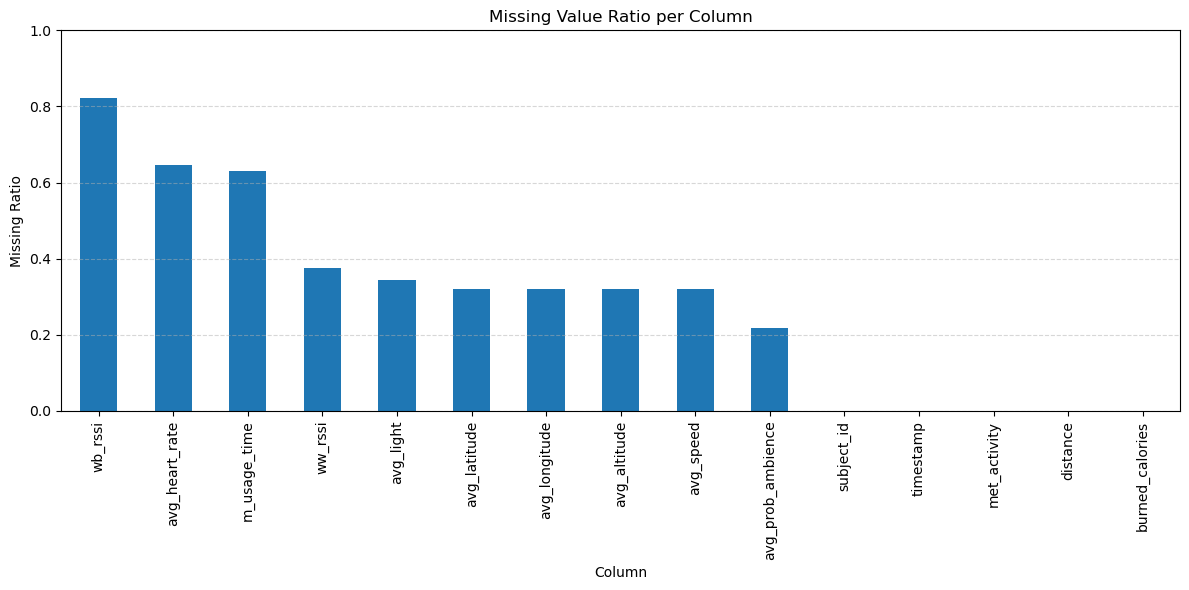

wb_rssi              100455
avg_heart_rate        78877
m_usage_time          77084
ww_rssi               45959
avg_light             42098
avg_latitude          39049
avg_longitude         39049
avg_altitude          39049
avg_speed             39049
avg_prob_ambience     26602
subject_id                0
timestamp                 0
met_activity              0
distance                  0
burned_calories           0
dtype: int64


In [ ]:
# Missing value analysis
missing_ratio = merge_df.isnull().mean()

# Graphical representation of missing values
plt.figure(figsize=(12, 6))
missing_ratio.sort_values(ascending=False).plot(kind='bar')
plt.title('Missing Value Ratio per Column')
plt.ylabel('Missing Ratio')
plt.xlabel('Column')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

missing_counts = merge_df.isnull().sum().sort_values(ascending=False)
print(missing_counts)


### Missing data imputation
1. wb_rssi
    1. 결측치인 부분들 모두 0 값 할당
2. avg_heart_rate
    1. row n-1 값과 row n+k+1 값의 평균으로 할당
    2. 그 후 결측치인  row 모두 삭제
3. m_usage_time
    1. 결측치인 부분들 모두 0 값 할당
4. ww_rssi
    1. 결측치인 부분들 모두 0 값 할당
5. avg_light
    1. 결측치인 부분들 모두 0 값 할당
6. avg_latitude, avg_longitude, avg_altitude, avg_speed
    1. 결측치인  row 모두 삭제
7. avg_prob_ambience
    1. 결측치인 부분들 모두 0 값 할당

In [83]:
gps_cols = ['avg_latitude', 'avg_longitude', 'avg_altitude', 'avg_speed']

for sid in merge_df['subject_id'].unique():
    mask = (merge_df['subject_id'] == sid)
    df_sid = merge_df[mask]

    # 1. wb_rssi: fill missing with 0
    merge_df.loc[mask, 'wb_rssi'] = df_sid['wb_rssi'].fillna(0)

    # 2. avg_heart_rate: interpolate with neighbors' mean for consecutive missing blocks
    idx_nan = df_sid['avg_heart_rate'][df_sid['avg_heart_rate'].isnull()].index
    # find consecutive NaN blocks
    nan_groups = (~df_sid['avg_heart_rate'].isnull()).cumsum()
    for k, group in df_sid['avg_heart_rate'][df_sid['avg_heart_rate'].isnull()].groupby(nan_groups):
        block_idx = group.index
        if len(block_idx) == 0:
            continue
        prev_idx = block_idx[0] - 1
        next_idx = block_idx[-1] + 1
        if prev_idx in df_sid.index and next_idx in df_sid.index:
            prev_val = df_sid.loc[prev_idx, 'avg_heart_rate']
            next_val = df_sid.loc[next_idx, 'avg_heart_rate']
            if not np.isnan(prev_val) and not np.isnan(next_val):
                mean_val = (prev_val + next_val) / 2
                merge_df.loc[block_idx, 'avg_heart_rate'] = mean_val
    
    heart_nan_rows = df_sid[df_sid['avg_heart_rate'].isnull()].index
    merge_df.drop(index=heart_nan_rows, inplace=True)

    # 3. m_usage_time: fill missing with 0
    merge_df.loc[mask, 'm_usage_time'] = df_sid['m_usage_time'].fillna(0)

    # 4. ww_rssi: fill missing with 0
    merge_df.loc[mask, 'ww_rssi'] = df_sid['ww_rssi'].fillna(0)

    # 5. avg_light: fill missing with 0
    merge_df.loc[mask, 'avg_light'] = df_sid['avg_light'].fillna(0)

    # 6. avg_latitude, avg_longitude, avg_altitude, avg_speed: drop rows with any missing
    gps_nan_rows = df_sid[df_sid[gps_cols].isnull().any(axis=1)].index
    merge_df.drop(index=gps_nan_rows, inplace=True)

    # 7. avg_prob_ambience: fill missing with 0
    merge_df.loc[mask, 'avg_prob_ambience'] = df_sid['avg_prob_ambience'].fillna(0)

# 인덱스 재정렬(필요시)
merge_df = merge_df.reset_index(drop=True)


In [ ]:
missing_counts = merge_df.isnull().sum().sort_values(ascending=False)
print(missing_counts)

subject_id           0
timestamp            0
m_usage_time         0
met_activity         0
wb_rssi              0
ww_rssi              0
avg_heart_rate       0
distance             0
burned_calories      0
avg_latitude         0
avg_longitude        0
avg_altitude         0
avg_speed            0
avg_light            0
avg_prob_ambience    0
dtype: int64


In [ ]:
merge_df.to_csv('merge_df.csv', index=False)